# WARNING
# The pca data used in such way that causes data leakage from train into test, interpret the results carefully

# Imports

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import numpy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from statistics import median
from math import log

# Load data

In [2]:
x_dict = {}
values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
              0.07, 0.08, 0.09, 0.1, 0.11, 0.12,
              0.13, 0.14, 0.15, 0.16, 0.17, 0.18,
              0.19, 0.2, 0.21, 0.22, 0.23, 0.24,
              0.25, 0.26, 0.27, 0.28, 0.29, 0.3,
              0.31, 0.32, 0.33, 0.34, 0.35, 0.36,
              0.37, 0.38, 0.39, 0.4, 0.41, 0.42,
              0.43, 0.44, 0.45, 0.46, 0.47, 0.48,
              0.49, 0.5, 0.51, 0.52, 0.53, 0.54,
              0.55, 0.56, 0.57, 0.58, 0.59, 0.6,
              0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
              0.67, 0.68, 0.69, 0.7, 0.71, 0.72,
              0.73, 0.74, 0.75, 0.76, 0.77, 0.78,
              0.79, 0.8, 0.81, 0.82, 0.83, 0.84,
              0.85, 0.86, 0.87, 0.88, 0.89, 0.9,
              0.91, 0.92, 0.93, 0.94, 0.95, 0.96,
              0.97, 0.98, 0.99, 0.9999]
values_str = [str(value) for value in values]
for value in values_str:
    split_x = {}
    split_x['test'] = pd.read_table(f'/mnt/genx-bio-share/TG/data/chip/test_split/pca_{value}/ALL/fold_0_test_projections.csv.eigenvec.sscore')
    split_x['train'] = pd.read_table(f'/mnt/genx-bio-share/TG/data/chip/test_split/pca_{value}/ALL/fold_0_train_projections.csv.eigenvec.sscore')
    split_x['val'] = pd.read_table(f'/mnt/genx-bio-share/TG/data/chip/test_split/pca_{value}/ALL/fold_0_val_projections.csv.eigenvec.sscore')

    split_x['test.fake'] = pd.read_table(f'/mnt/genx-bio-share/TG/data/chip/test_split/pca_{value}/ALL.fake/fold_0_test_projections.csv.eigenvec.sscore')
    split_x['train.fake'] = pd.read_table(f'/mnt/genx-bio-share/TG/data/chip/test_split/pca_{value}/ALL.fake/fold_0_train_projections.csv.eigenvec.sscore')
    split_x['val.fake'] = pd.read_table(f'/mnt/genx-bio-share/TG/data/chip/test_split/pca_{value}/ALL.fake/fold_0_val_projections.csv.eigenvec.sscore')

    x_dict[value] = split_x


test_y = pd.read_table('/mnt/genx-bio-share/TG/data/chip/test_split/only_phenotypes/ancestry/ALL/fold_0_test.tsv')
train_y = pd.read_table('/mnt/genx-bio-share/TG/data/chip/test_split/only_phenotypes/ancestry/ALL/fold_0_train.tsv')
val_y = pd.read_table('/mnt/genx-bio-share/TG/data/chip/test_split/only_phenotypes/ancestry/ALL/fold_0_val.tsv')

# Process data

In [4]:
# Loading into pandas
y = pd.concat([val_y, test_y, train_y]).rename_axis('index').reset_index()
for value in values_str:
    x_dict[value+'prune'] = pd.concat([x_dict[value]['val'], x_dict[value]['test'], x_dict[value]['train']]).rename(columns={'#IID': 'IID'}).set_index('IID').filter(regex='^PC*').reindex(y.set_index('IID').index)
    x_dict[value+'.fake'] = pd.concat([x_dict[value]['val.fake'], x_dict[value]['test.fake'], x_dict[value]['train.fake']]).rename(columns={'#IID': 'IID'}).set_index('IID').filter(regex='^PC*').reindex(y.set_index('IID').index)
    x_dict[value+'_np'] = x_dict[value + 'prune'].values
    x_dict[value+'.fake'+'_np'] = x_dict[value+'.fake'].values

# Converting into numpy
_, y_np = numpy.unique(y.iloc[:, -1].values.astype(numpy.ndarray), return_inverse=True)

# Load and process data from superpop split

In [ ]:
split_nop = {}
split_nop['test'] = pd.read_table(f'/mnt/genx-bio-share/TG/data/chip/superpop_split/pca/ALL/fold_0_test_projections.csv.eigenvec.sscore')
split_nop['train'] = pd.read_table(f'/mnt/genx-bio-share/TG/data/chip/superpop_split/pca/ALL/fold_0_train_projections.csv.eigenvec.sscore')
split_nop['val'] = pd.read_table(f'/mnt/genx-bio-share/TG/data/chip/superpop_split/pca/ALL/fold_0_val_projections.csv.eigenvec.sscore')

y = pd.concat([val_y, test_y, train_y]).rename_axis('index').reset_index()
split_nop['prune'] = pd.concat([split_nop['val'], split_nop['test'], split_nop['train']]).rename(columns={'#IID': 'IID'}).set_index('IID').filter(regex='^PC*').reindex(y.set_index('IID').index)
split_nop['_np'] = split_nop['prune'].values


# Converting into numpy
_, y_np = numpy.unique(y.iloc[:, -1].values.astype(numpy.ndarray), return_inverse=True)

# Model and training

In [5]:
model = RandomForestClassifier(min_samples_leaf=1,
                               n_estimators=100)

# Train on superpop split(no pruning)

In [12]:
value_nop = []
from tqdm import tqdm
for i in tqdm(range(20)):
    scores = cross_validate(model, split_nop['_np'], y_np, cv=10, return_train_score=True)
    value_nop += scores["test_score"].tolist()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:06<00:00,  9.31s/it]


# Train on pruned data

In [9]:
scores_total = {}
for value in values_str:
    value_score = {}
    value_score['train'] = []
    value_score['test'] = []
    for i in range(4):
        scores = cross_validate(model, x_dict[value + '_np'], y_np, cv=10, return_train_score=True)
        value_score['train'] += scores["train_score"].tolist()
        value_score['test'] += scores["test_score"].tolist()
    print(f"Pruning\n"
          f"VALUE: {value}\n"
          f"Train accuracies: {value_score['train']}\n"
      f"Test accuracies: {value_score['test']}")
    value_score['train.fake'] = []
    value_score['test.fake'] = []
    for i in range(4):
        scores = cross_validate(model, x_dict[value +'.fake'+ '_np'], y_np, cv=10, return_train_score=True)
        value_score['train.fake'] += scores["train_score"].tolist()
        value_score['test.fake'] += scores["test_score"].tolist()
    scores_total[value] = value_score
    print(f"FAKE\n"
          f"VALUE: {value}\n"
          f"Train accuracies: {value_score['train.fake']}\n"
      f"Test accuracies: {value_score['test.fake']}")

Pruning
VALUE: 0.01
Train accuracies: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Test accuracies: [0.8060836501901141, 0.8365019011406845, 0.8669201520912547, 0.8859315589353612, 0.8816793893129771, 0.8549618320610687, 0.8816793893129771, 0.8664122137404581, 0.8893129770992366, 0.8702290076335878, 0.8060836501901141, 0.8288973384030418, 0.870722433460076, 0.8745247148288974, 0.8664122137404581, 0.8549618320610687, 0.9045801526717557, 0.8778625954198473, 0.8893129770992366, 0.8931297709923665, 0.8136882129277566, 0.8326996197718631, 0.8593155893536122, 0.8593155893536122, 0.8702290076335878, 0.8702290076335878, 0.9007633587786259, 0.8702290076335878, 0.8931297709923665, 0.8931297709923665, 0.8098859315589354, 0.844106463878327, 0.8669201520912547, 0.8669201520912547, 0.8587786259541985, 0.851145038167939, 0.8854961832061069, 0.8740

# Get percentage of variants for each pruning threshold

In [40]:
count_var = {}
for value in values_str:
    lines = sum(1 for line in open(f'/mnt/genx-bio-share/TG/data/chip/test_split/genotypes/ALL.{value}.prune.in'))
    count_var[value] = lines/3671378

# Convert data and plot the results

In [35]:
scores_fake = {}
for value in scores_total:
    scores_fake[value] = scores_total[value]['test.fake']
df_fake = pd.melt(pd.DataFrame.from_dict(scores_fake))
df_fake['variable'] = pd.to_numeric(df_fake['variable'])

scores_real = {}
for value in scores_total:
    scores_real[value] = scores_total[value]['test']
df_real = pd.melt(pd.DataFrame.from_dict(scores_real))
df_real['variable'] = pd.to_numeric(df_real['variable'])


scores_nop = {}
scores_nop['1'] = [float(value) for value in value_nop]
df_nop = pd.melt(pd.DataFrame.from_dict(scores_nop))
df_nop['variable'] = pd.to_numeric(df_nop['variable'])
df_real = pd.concat([df_real, df_nop])
df_fake = pd.concat([df_fake, df_nop])

## How number of variants depends on threshold

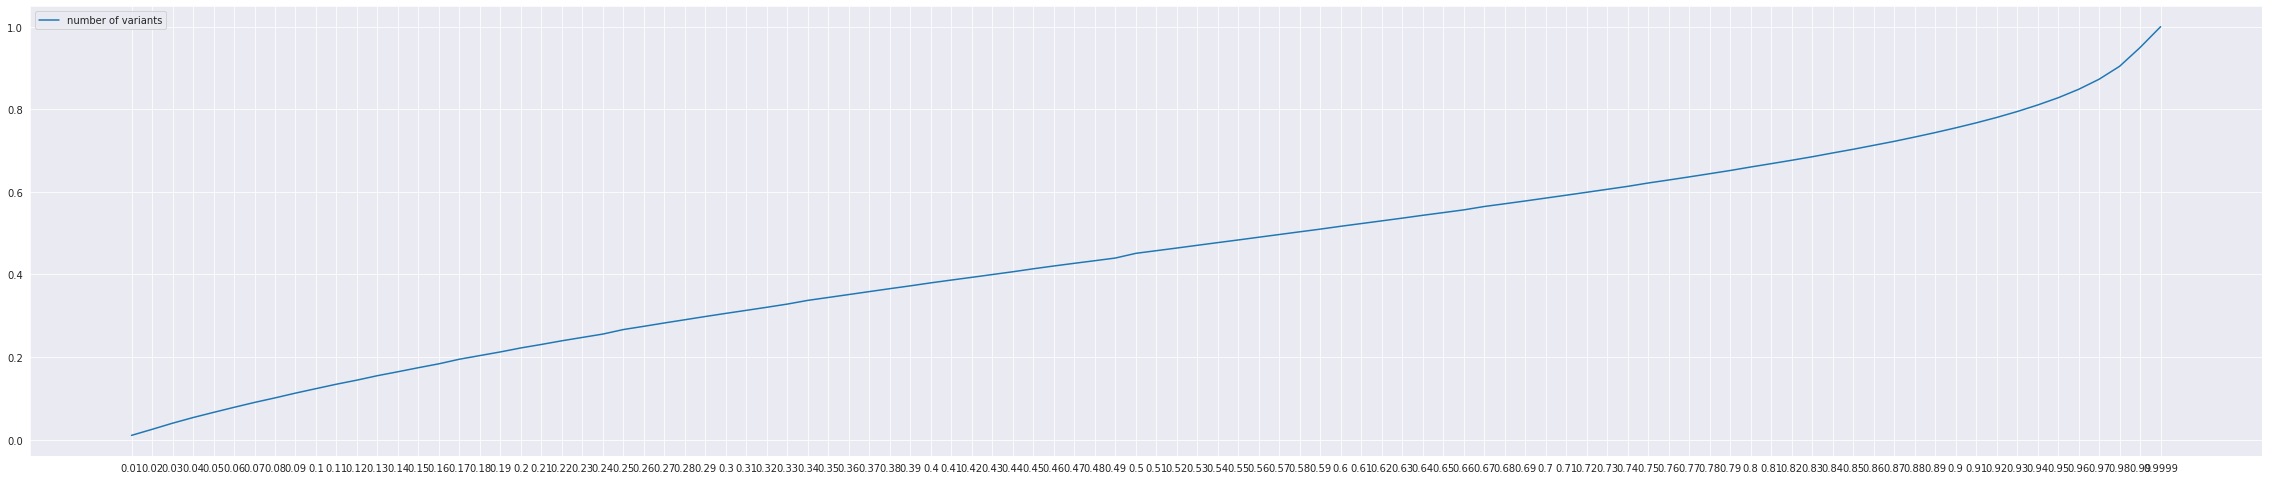

In [43]:
a4_dims = (40, 8.27)
keys = values_str
counts = [count_var[k] for k in keys]
fig, ax = pyplot.subplots(figsize=a4_dims)
plot = sns.lineplot(x=keys, y=counts, label="number of variants", ax=ax)

## How random forest perfomance depends on pruning threshold
### Blue boxes represent accuracies on pruning
### Red boxes represent accuracies on fake pruning(randomly selected samples)

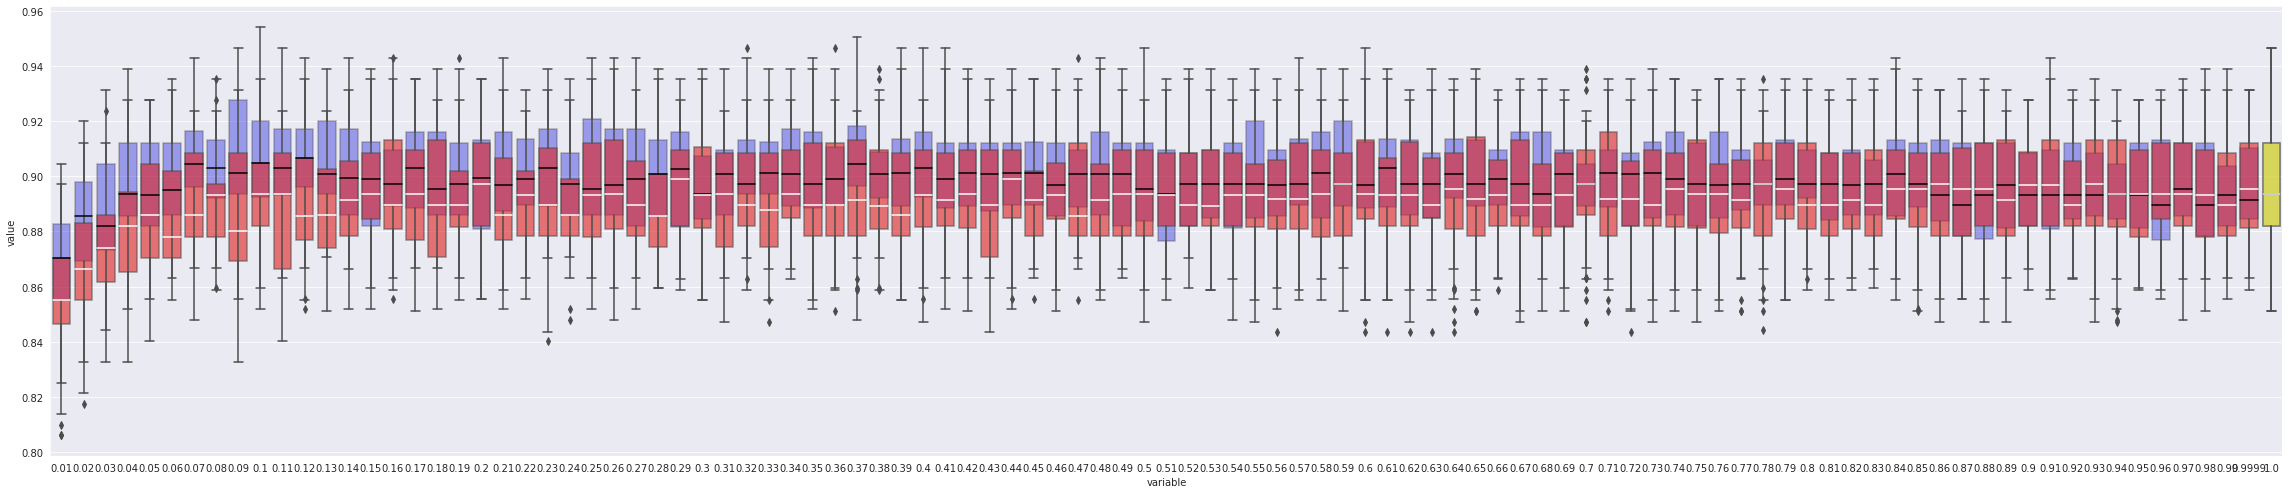

In [42]:
a4_dims = (40, 8.27)

fig, ax = pyplot.subplots(figsize=a4_dims)

plot = sns.boxplot(x='variable', y='value', data=df_real, ax=ax, boxprops=dict(alpha=.4), color="blue", medianprops={'color':'black'})
plot = sns.boxplot(x='variable', y='value', data=df_fake, ax=ax, boxprops=dict(alpha=.6), color="red", medianprops={'color':'white'})
mybox = plot.patches[-1] # `patches` instead of `artists`

# Change the appearance of that box
mybox.set_facecolor('yellow')

## Check results for statistical significance with ANOVA

In [27]:
import scipy
for value in scores_total:
    m = median(scores_total[value]['test']) > median(value_nop)
    if scipy.stats.f_oneway(scores_total[value]['test'], scores_total[value]['test.fake'], value_nop).pvalue <= 0.05 and m:
        print(value)

0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.23
0.28
0.37


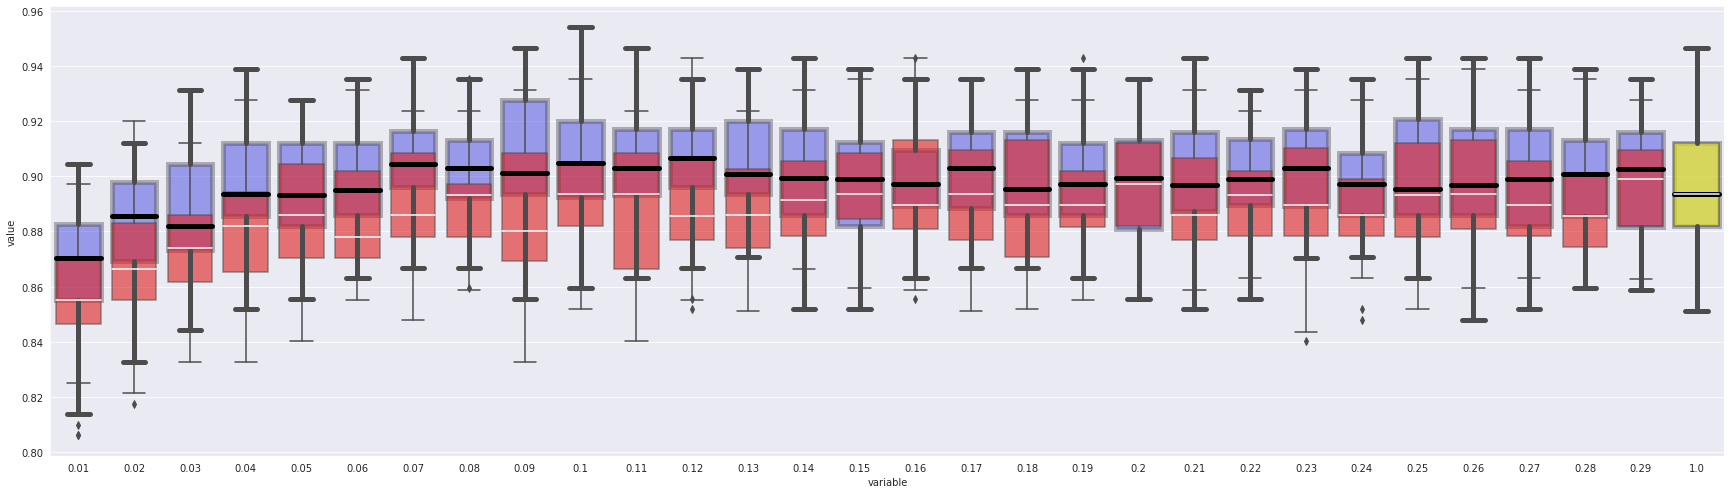

In [30]:
a4_dims = (30, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
plot = sns.boxplot(x='variable', y='value', medianprops={'color':'black'}, data=df_real.loc[(df_real['variable'] < 0.3) | (df_real['variable'] == 1.0)], ax=ax, boxprops=dict(alpha=.4), color="blue", linewidth=5)
plot = sns.boxplot(x='variable', y='value', medianprops={'color':'white'}, data=df_fake.loc[(df_fake['variable'] < 0.3) | (df_real['variable'] == 1.0)], ax=ax, boxprops=dict(alpha=.6), color="red")
mybox = plot.patches[-1]
mybox.set_facecolor('yellow')

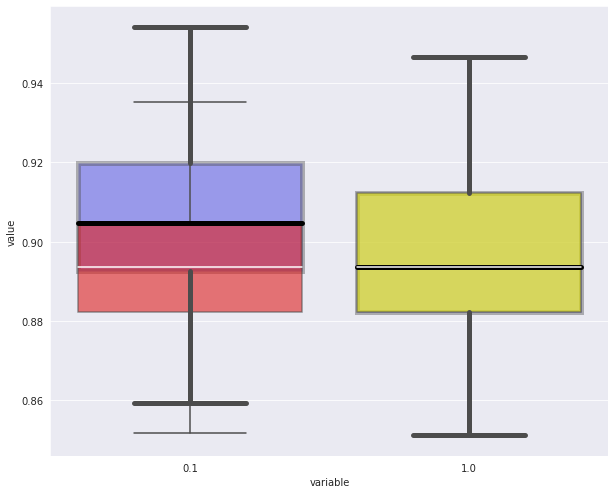

In [45]:
a4_dims = (10, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
plot = sns.boxplot(x='variable', y='value', medianprops={'color':'black'}, data=df_real.loc[(df_real['variable'] == 0.1) | (df_real['variable'] == 1.0)], ax=ax, boxprops=dict(alpha=.4), color="blue", linewidth=5)
plot = sns.boxplot(x='variable', y='value', medianprops={'color':'white'}, data=df_fake.loc[(df_fake['variable'] == 0.1) | (df_real['variable'] == 1.0)], ax=ax, boxprops=dict(alpha=.6), color="red")
mybox = plot.patches[-1]
mybox.set_facecolor('yellow')

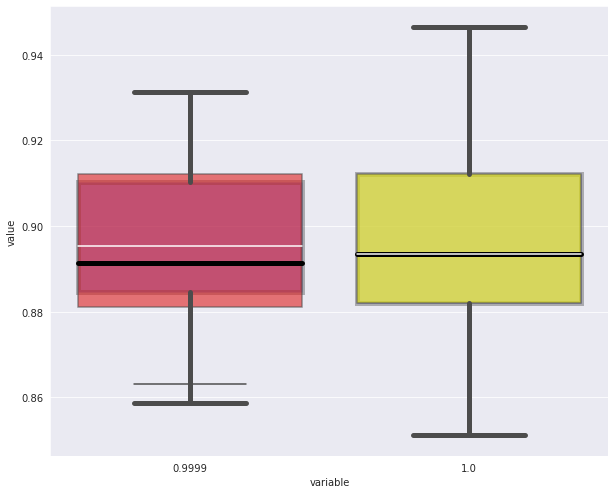

In [47]:
a4_dims = (10, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
plot = sns.boxplot(x='variable', y='value', medianprops={'color':'black'}, data=df_real.loc[(df_real['variable'] == 0.9999) | (df_real['variable'] == 1.0)], ax=ax, boxprops=dict(alpha=.4), color="blue", linewidth=5)
plot = sns.boxplot(x='variable', y='value', medianprops={'color':'white'}, data=df_fake.loc[(df_fake['variable'] == 0.9999) | (df_real['variable'] == 1.0)], ax=ax, boxprops=dict(alpha=.6), color="red")
mybox = plot.patches[-1]
mybox.set_facecolor('yellow')
